# Models to predict PCE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import math
import statistics
from scipy.stats import sem
from scipy import stats

from pathlib import Path

import statsmodels.api as sm
from xgboost import XGBRFRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import check_consistent_length
from sklearn.utils import check_array
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense


import warnings
warnings.filterwarnings("ignore")

In [10]:
data = pd.read_csv('descriptors_with_fingerprints.csv')
print('Number of donor-acceptor pairs is: ' + str(len(data)))

Number of donor-acceptor pairs is: 999


In [11]:
data_highPCE = data[data['PCE'] > 10]
print('Number of donor-acceptor pairs with a PCE greater than 10% is: ' + str(len(data_highPCE)))

Number of donor-acceptor pairs with a PCE greater than 10% is: 503


## LASSO

In [17]:
# Will tune the descriptors down to 6 until to achieve an optimized RMSE
# returns a list of the top 6 descriptors
def optimize_eq(df, target):
    
    all_descriptors = ['A-HOMO', 'A-HOMOminus1', 'A-LUMO', 'A-LUMOplus1', 'A-fundbg', 'A-deltaHOMO', 'A-deltaLUMO', 'A-opt_bg', 'A-max_abs', 'A-summed_oscs', 'A-area_spectra', 'A-area_sim_solar_spectra', 'A-chemical_potential', 'A-electrophilicity', 'A-pi_sys_size', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'A-NumHAcceptors', 'A-NumHDonors', 'A-RingCount', 'A-planarity','A-dipole_moment', 'A-polarizability', 'A-SolvationEnergy_water', 'A-SolvationEnergy_hexane', 'D-HOMO', 'D-HOMOminus1', 'D-LUMO', 'D-LUMOplus1', 'D-fundbg', 'D-deltaHOMO', 'D-deltaLUMO', 'D-opt_bg', 'D-max_abs', 'D-summed_oscs', 'D-area_spectra', 'D-area_sim_solar_spectra', 'D-chemical_potential', 'D-electrophilicity', 'D-pi_sys_size', 'D-num_rot_bonds', 'D-MolLogP', 'D-TPSA', 'D-NumHAcceptors', 'D-NumHDonors', 'D-RingCount', 'D-planarity','D-dipole_moment', 'D-polarizability', 'D-SolvationEnergy_water', 'D-SolvationEnergy_hexane', 'AD-overlap', 'AD-HOMOoffset', 'AD-LUMOoffset', 'DHOMO_ALUMO_offset']
    
    # LASSO to remove any with coefficients of zero
    descriptors_to_remove = []
    results = evaluate_model(all_descriptors, df[target], df,output=False)
    for x in range(len(results[9])):
        if results[9][x][1] == 0.0:
            descriptors_to_remove.append(results[9][x][0])
            
    for x in descriptors_to_remove:
        all_descriptors.remove(x)
    print(all_descriptors)
    
    while len(all_descriptors) > 8:
        rmse = 100.0
        diff = 0.0
        mae = 100.0
        r2 = -1.00
        for x in range(len(all_descriptors)):
            temp_descriptor = all_descriptors[x]
            new_list = all_descriptors.copy()
            new_list.remove(temp_descriptor)
            results = evaluate_model(new_list, df[target], df,output=False)
            new_diff = 100.0 - float(results[4])
            
            if new_diff >= diff:
                if new_diff == diff:
                    if mae == results[2]:
                        if results[0] > r2:
                            diff = new_diff
                            mae = results[2]
                            r2 = results[0]
                            rmse = results[4]
                            best_list = new_list
                    elif mae > results[2]:
                        diff = new_diff
                        mae = results[2]
                        r2 = results[0]
                        rmse = results[4]
                        best_list = new_list
                else:
                    diff = new_diff
                    mae = results[2]
                    r2 = results[0]
                    rmse = results[4]
                    best_list = new_list
                
        all_descriptors = best_list
        print(len(all_descriptors))
        print(rmse)
        
    print(all_descriptors)
    print(rmse)
    
    return all_descriptors

## from sci-kit-learn https://github.com/scikit-learn/scikit-learn/blob/4773f3e39/sklearn/metrics/_regression.py#L197
def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):

    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def evaluate_model(list_of_desc, target, dataframe, cf = False, output=True):
    '''
    Evaluates the errors of the proposed model
    
    Parameters
    ---------
    list_of_desc = name of the list that contains the descriptors
    target = target experimental value in the dataframe. Ex: df_highPCE['ExperimentalJsc']
    dataframe = name of dataframe to use descriptors from
    cf = should it show the coefficients
    
    Returns
    -------
    R2, MAE, RMSE, MAPE, y-intercept of equation, coefficients of each descriptor, average predictions
    '''
    
    new_df = dataframe[list_of_desc].copy()
    
    max_mae = 10.0
    best_alpha = 0
    for a in range(1,200):
        lm =Lasso(alpha=float(a)/100.0)
        lm.fit(new_df, target)
        mae = mean_absolute_error(target, lm.predict(new_df))
        if mae < max_mae:
            best_alpha = float(a)/100.0
            max_mae = mae

    r2_score = []
    intercepts = []
    coefs = []
    predicted_PCE = []
    MAE_cv = []
    RMSE_cv = []
    
    print('Best alpha is', best_alpha)

    PCE_cv = cross_validate(Lasso(alpha = best_alpha, max_iter = 100000), new_df, target, cv=5, scoring = ['neg_mean_squared_error'] , return_estimator = True)
    for x in PCE_cv['estimator']:
        coef = x.coef_
        coefs.append(coef)

        pred = x.predict(new_df)
        predicted_PCE.append(pred)

        r2_score.append(x.score(new_df, target))
        intercepts.append(x.intercept_)

        
    avg_coef = sum(coefs)/5.0    
    zipped_coefs = zip(list_of_desc, avg_coef)
    
    if output == True:
        if cf == True:
            print('The average intercept from 5 folds is ', statistics.mean(intercepts))
            print('The average coefficients of the 5 folds is ', list(zipped_coefs))
    
    coefficients = list(zipped_coefs)
    
    avg_pred = sum(predicted_PCE)/ 5.0    
    all_mae = []
    all_RMSE = []
    all_MAPE = []
    for x in range(len(predicted_PCE)):
        mae = mean_absolute_error(target, predicted_PCE[x])
        all_mae.append(mae)
        mse = mean_squared_error(target, predicted_PCE[x])
        rmse = math.sqrt(mse)
        all_RMSE.append(rmse)
        mape = mean_absolute_percentage_error(target, predicted_PCE[x]) * 100
        all_MAPE.append(mape)
    SEM_mae = round(sem(all_mae), 3)
    SEM_RMSE = round(sem(all_RMSE), 5)
    SEM_MAPE = round(sem(all_MAPE), 5)
    
    
    mean_MAE = round(statistics.mean(all_mae), 3)
    mean_RMSE = round(statistics.mean(all_RMSE), 4)
    mean_MAPE = round(statistics.mean(all_MAPE), 4)
    SEM_r2 = round(sem(r2_score), 3)
    
    if output == True:
        print('The 5-fold cross-validated RMSE of this model is, ', mean_RMSE, ' +/- ', SEM_RMSE)
        print('The 5-fold cross-validated MAE of the average ', mean_MAE, ' +/- ', SEM_mae)
        print('The average r^2 value is ', statistics.mean(r2_score), ' +/- ', SEM_r2 )
    mean_r2 = round(statistics.mean(r2_score), 3)
    
    intercept = statistics.mean(intercepts)
    
    return mean_r2, SEM_r2, mean_MAE, SEM_mae, mean_RMSE, SEM_RMSE, mean_MAPE, SEM_MAPE, intercept, coefficients, avg_pred

In [13]:
#https://www.programcreek.com/python/example/99249/sklearn.linear_model.LassoCV

def load_default(self, machine_list='basic'):
        """
        Loads 4 different scikit-learn regressors by default. The advanced list adds more machines. 

        Parameters
        ----------
        machine_list: optional, list of strings
            List of default machine names to be loaded.
        Returns
        -------
        self : returns an instance of self.
        """

        if machine_list == 'basic':
            machine_list = ['tree', 'ridge', 'random_forest', 'svm']
        if machine_list == 'advanced':
            machine_list=['lasso', 'tree', 'ridge', 'random_forest', 'svm', 'bayesian_ridge', 'sgd']

        self.estimators_ = {}
        for machine in machine_list:
            try:
                if machine == 'lasso':
                    self.estimators_['lasso'] = linear_model.LassoCV(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'tree':
                    self.estimators_['tree'] = DecisionTreeRegressor(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'ridge':
                    self.estimators_['ridge'] = linear_model.RidgeCV().fit(self.X_k_, self.y_k_)
                if machine == 'random_forest':
                    self.estimators_['random_forest'] = RandomForestRegressor(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'svm':
                    self.estimators_['svm'] = LinearSVR(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'sgd':
                    self.estimators_['sgd'] = linear_model.SGDRegressor(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                if machine == 'bayesian_ridge':
                    self.estimators_['bayesian_ridge'] = linear_model.BayesianRidge().fit(self.X_k_, self.y_k_)
            except ValueError:
                continue
        return self 

Lets see which descriptors LASSO selects:

In [14]:
all_descriptors = ['A-HOMO', 'A-HOMOminus1', 'A-LUMO', 'A-LUMOplus1', 'A-fundbg', 'A-deltaHOMO', 'A-deltaLUMO', 'A-opt_bg', 'A-max_abs', 'A-summed_oscs', 'A-area_spectra', 'A-area_sim_solar_spectra', 'A-chemical_potential', 'A-electrophilicity', 'A-pi_sys_size', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'A-NumHAcceptors', 'A-NumHDonors', 'A-RingCount', 'A-planarity','A-dipole_moment', 'A-polarizability', 'A-SolvationEnergy_water', 'A-SolvationEnergy_hexane', 'D-HOMO', 'D-HOMOminus1', 'D-LUMO', 'D-LUMOplus1', 'D-fundbg', 'D-deltaHOMO', 'D-deltaLUMO', 'D-opt_bg', 'D-max_abs', 'D-summed_oscs', 'D-area_spectra', 'D-area_sim_solar_spectra', 'D-chemical_potential', 'D-electrophilicity', 'D-pi_sys_size', 'D-num_rot_bonds', 'D-MolLogP', 'D-TPSA', 'D-NumHAcceptors', 'D-NumHDonors', 'D-RingCount', 'D-planarity','D-dipole_moment', 'D-polarizability', 'D-SolvationEnergy_water', 'D-SolvationEnergy_hexane', 'AD-overlap', 'AD-HOMOoffset', 'AD-LUMOoffset', 'DHOMO_ALUMO_offset']
print("There are " + str(len(all_descriptors)) + ' descriptors')

There are 56 descriptors


In [15]:
Lasso_PCE = evaluate_model(all_descriptors, data['PCE'], data, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -47.38757239637007
The average coefficients of the 5 folds is  [('A-HOMO', 0.0), ('A-HOMOminus1', 0.0), ('A-LUMO', -0.04882236075415286), ('A-LUMOplus1', -0.2015438690236909), ('A-fundbg', 0.0), ('A-deltaHOMO', -2.0170885567343686), ('A-deltaLUMO', -0.24370157033836576), ('A-opt_bg', -0.0005866894610065203), ('A-max_abs', 0.014867711507319609), ('A-summed_oscs', -0.17175346537976693), ('A-area_spectra', -0.0030290807766185012), ('A-area_sim_solar_spectra', 0.2051748545984285), ('A-chemical_potential', 0.0), ('A-electrophilicity', -0.025838391600273198), ('A-pi_sys_size', -0.04599825008037868), ('A-num_rot_bonds', -0.404151000414417), ('A-MolLogP', 0.337854734879463), ('A-TPSA', 0.021322106811522516), ('A-NumHAcceptors', 0.04879788506481016), ('A-NumHDonors', 0.0), ('A-RingCount', -0.0844654088687202), ('A-planarity', -0.38769472281142325), ('A-dipole_moment', -0.044170580476774114), ('A-polarizability', 0.000375179912725825), ('

When the coefficient is zero, it means there is no correlation between the descriptor and the PCE, so it can be discarded.  
The following descriptors were zeroed out:
1. HOMO (acc & don)
2. HOMO-1 (acc)
3. fundamental bandgap (acc & don)
4. optical bandgap (acc & don)
5. chemical potential (acc & don)
6. NumHDonors (acc & don)
7. Solvation energies for water and hexane (acc & don)
8. deltaHOMO (don)
9. deltaLUMO (don)
10. HOMO offset between donor and acceptor
11. Offset between donor HOMO and acceptor LUMO

The remaining descriptors are hand-tuned to lower the RMSE

In [19]:
#best_descriptors = optimize_eq(data, 'PCE')
Lasso_PCE = evaluate_model(best_descriptors, data['PCE'], data, cf=True)

['A-LUMO', 'A-LUMOplus1', 'A-deltaHOMO', 'A-deltaLUMO', 'A-max_abs', 'A-summed_oscs', 'A-area_spectra', 'A-area_sim_solar_spectra', 'A-electrophilicity', 'A-pi_sys_size', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'A-NumHAcceptors', 'A-planarity', 'A-dipole_moment', 'A-polarizability', 'D-HOMOminus1', 'D-LUMO', 'D-LUMOplus1', 'D-max_abs', 'D-summed_oscs', 'D-area_spectra', 'D-area_sim_solar_spectra', 'D-electrophilicity', 'D-pi_sys_size', 'D-num_rot_bonds', 'D-MolLogP', 'D-TPSA', 'D-NumHAcceptors', 'D-planarity', 'D-dipole_moment', 'D-polarizability', 'AD-overlap', 'AD-LUMOoffset']


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.781293106398152, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.384951783514225, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.786145665426375, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

34
2.9135


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.383602071324276, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.775178613127537, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.57423568455124, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

33
2.9108


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.301351982651795, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.025165096245473, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7502440586868033, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

32
2.9095


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.306155209224016, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.057061871975748, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7463449306924304, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

31
2.9085


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.001718903598885, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9781181618564005, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7062921895540057, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

30
2.9082


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.071758336947823, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.020821837357289, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7129853078440647, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

29
2.9081


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.42211745480563, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1097545924567385, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.308612215823814, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

28
2.908


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9619208471431193, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8328546311240643, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.075441451432198, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

27
2.9079


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.741228766439235, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7996958278818056, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.026895278819211, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

26
2.9079


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.741228766439235, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7996958278818056, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.026916922037344, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

25
2.9079


C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.252493299627531, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2570693885936635, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.369651469778546, tolerance: 1.4507535502977023
  model = cd_fast.enet_coordinate_descent(
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

24
2.908
23
2.908
22
2.908
21
2.9081
20
2.9083
19
2.9085
18
2.9079
17
2.9119
16
2.9155
15
2.9187
14
2.9229
13
2.927
12
2.9388
11
2.9556
10
2.9842
9
3.0081
8
3.0222
7
3.0494
6
3.0993
['A-electrophilicity', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'D-HOMOminus1', 'D-NumHAcceptors']
3.0993
The average intercept from 5 folds is  -51.57087072184057
The average coefficients of the 5 folds is  [('A-HOMO', 0.0), ('A-HOMOminus1', 0.0), ('A-LUMO', -0.17545975271623135), ('A-LUMOplus1', -0.37452985792697435), ('A-fundbg', 0.0), ('A-deltaHOMO', -2.257287427054922), ('A-deltaLUMO', -0.0010517494440340231), ('A-opt_bg', 0.0), ('A-max_abs', 0.012185671244768142), ('A-summed_oscs', -0.11552792341660978), ('A-area_spectra', -0.0024600261908346815), ('A-area_sim_solar_spectra', 0.06207173287218095), ('A-chemical_potential', 0.0), ('A-electrophilicity', -0.03011792426999103), ('A-pi_sys_size', -0.03922436041426376), ('A-num_rot_bonds', -0.39931444393768434), ('A-MolLogP', 0.3033117383147984), ('A-TPSA',

In [103]:
best_descriptors = ['A-electrophilicity', 'A-num_rot_bonds', 'A-MolLogP', 'A-TPSA', 'D-HOMOminus1', 'D-NumHAcceptors']
Lasso_PCE = evaluate_model(best_descriptors, data['PCE'], data, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -36.82762357618022
The average coefficients of the 5 folds is  [('A-electrophilicity', -0.03673272675818182), ('A-num_rot_bonds', -0.3919236925943181), ('A-MolLogP', 0.12724213816888424), ('A-TPSA', 0.010438720700639826), ('D-HOMOminus1', -3.849560022147473), ('D-NumHAcceptors', 0.2502317935054116)]
The 5-fold cross-validated RMSE of this model is,  3.0993  +/-  0.00088
The 5-fold cross-validated MAE of the average  2.389  +/-  0.005
The average r^2 value is  0.3372375057734442  +/-  0.0


Using LASSO and some hand-tuning to narrow it down to 6 descriptors, the RMSE of this model is 3.0993 +/- 0.00088 for the PCE. The $R^2$ is 0.337. The descriptors selected is the electrophilicity index of the acceptor, number of rotatable bonds of the acceptor, MolLogP of the acceptor, TPSA of the acceptor, HOMO-1 of the donor, and number of hydrogen acceptors of the donor

### Performance on PCE > 10%

In [16]:
Lasso_highPCE = evaluate_model(all_descriptors, data_highPCE['PCE'], data_highPCE, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -11.513850156052039
The average coefficients of the 5 folds is  [('A-HOMO', 0.0), ('A-HOMOminus1', 0.0), ('A-LUMO', 0.0), ('A-LUMOplus1', -0.7049534956656617), ('A-fundbg', 0.0), ('A-deltaHOMO', -2.121462851530139), ('A-deltaLUMO', 0.0), ('A-opt_bg', 0.0), ('A-max_abs', 0.011421667421522202), ('A-summed_oscs', -0.2247221104885379), ('A-area_spectra', -0.0015466615727089867), ('A-area_sim_solar_spectra', 0.464514918259573), ('A-chemical_potential', 0.0), ('A-electrophilicity', -0.006314366764445796), ('A-pi_sys_size', -0.040522031107699495), ('A-num_rot_bonds', -0.11609582244389387), ('A-MolLogP', 0.13513432383667234), ('A-TPSA', 0.0013573775176714768), ('A-NumHAcceptors', 0.10115431934774391), ('A-NumHDonors', -0.1771381772989141), ('A-RingCount', 0.14754188685927655), ('A-planarity', -0.18058750830251555), ('A-dipole_moment', -0.03541930306629818), ('A-polarizability', -0.004390787538192751), ('A-SolvationEnergy_water', 0.0), (

In [19]:
#best_descriptors = optimize_eq(data_highPCE, 'PCE')
best_descriptors = ['A-deltaHOMO', 'A-max_abs', 'A-num_rot_bonds', 'D-area_spectra', 'D-electrophilicity', 'D-TPSA', 'D-NumHAcceptors', 'AD-overlap']
Lasso_PCE = evaluate_model(best_descriptors, data_highPCE['PCE'], data_highPCE, cf=True)

Best alpha is 0.01
The average intercept from 5 folds is  -4.267204924215006
The average coefficients of the 5 folds is  [('A-deltaHOMO', -2.083737185992404), ('A-max_abs', 0.013736351224865473), ('A-num_rot_bonds', -0.18542951442278338), ('D-area_spectra', -0.0006769547389177241), ('D-electrophilicity', 0.04156378924271681), ('D-TPSA', -0.01456558372358307), ('D-NumHAcceptors', 0.09444544003183006), ('AD-overlap', 0.0022508957326855894)]
The 5-fold cross-validated RMSE of this model is,  1.4833  +/-  0.00072
The 5-fold cross-validated MAE of the average  1.187  +/-  0.001
The average r^2 value is  0.4057400141644918  +/-  0.001


# Machine Learning

Sets X as all input descriptors and y as the PCE

In [4]:
X = data.iloc[:, 8:]
y = data.iloc[:, 7:8]

Split into training (80%) and testing (20%) sets

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

Standardizes the data so all values are centered around 0 and have variance of the same magnitude

In [8]:
'''x_labels = x_train.columns

scaler = StandardScaler().fit(x_train[x_labels]) 

x_train[x_labels] = scaler.transform(x_train[x_labels])

x_test[x_labels] = scaler.transform(x_test[x_labels])'''

Optimize alpha

In [6]:
lasso = LassoCV(cv=5, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
print('Best alpha is ' + str(lasso.alpha_))

print(list(zip(lasso.coef_, X)))
print('R squared training set', round(lasso.score(x_train, y_train), 2))
print('R squared test set', round(lasso.score(x_test, y_test), 2))

Best alpha is 0.7704750571710461
[(-0.0, 'A-HOMO'), (0.0, 'A-HOMOminus1'), (-0.0, 'A-LUMO'), (-0.0, 'A-LUMOplus1'), (-0.0, 'A-fundbg'), (-0.0, 'A-deltaHOMO'), (-0.0, 'A-deltaLUMO'), (-0.0, 'A-opt_bg'), (0.017641186867352908, 'A-max_abs'), (0.0, 'A-summed_oscs'), (-0.0001404467196195648, 'A-area_spectra'), (0.0, 'A-area_sim_solar_spectra'), (-0.0, 'A-chemical_potential'), (-0.019170290099192057, 'A-electrophilicity'), (-0.02482452620409847, 'A-pi_sys_size'), (-0.239271484909954, 'A-num_rot_bonds'), (0.021551740089278786, 'A-MolLogP'), (0.013085813850718133, 'A-TPSA'), (0.0, 'A-NumHAcceptors'), (-0.0, 'A-NumHDonors'), (-0.0, 'A-planarity'), (-0.011609710654258832, 'A-dipole_moment'), (0.0016297906802177796, 'A-polarizability'), (-0.0, 'A-SolvationEnergy_water'), (0.0, 'A-SolvationEnergy_hexane'), (-0.0, 'D-HOMO'), (-0.0, 'D-HOMOminus1'), (-0.0, 'D-LUMO'), (-0.0, 'D-LUMOplus1'), (-0.0, 'D-fundbg'), (-0.0, 'D-deltaHOMO'), (-0.0, 'D-deltaLUMO'), (-0.0, 'D-opt_bg'), (0.001697891868806389, 'D

Visualize the optimization of alpha

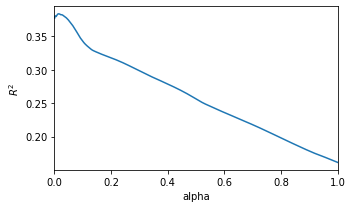

In [97]:
alphas = np.linspace(0.001,1,1000)
lasso = Lasso(max_iter=10000)

scores = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    
    #scores.append(lasso.score(x_train, y_train))
    scores.append(cross_val_score(lasso, x_train, y_train, cv=5).mean())

plt.figure(figsize=(5, 3))  
plt.plot(alphas, scores)
plt.xlim([0, 1])
plt.xlabel('alpha')
plt.ylabel('$R^2$')
plt.tight_layout()
plt.savefig('lasso_cv_alpha.pdf', dpi=600)
plt.show()

Final model metrics

In [4]:
def model_metrics(model, X, y, cv=5):
    score = cross_val_score(model, X, y, cv=cv, scoring = 'r2')
    SEM_r2 = round((score.std() / math.sqrt(5)) , 3)
    #r2 = str(round(score.mean(), 3)) + ' +/- ' +  str(SEM_r2)
    r2 = round(float(score.mean()), 3)
    print('R^2: ' + str(r2) + ' +/- ' +  str(SEM_r2))
    
    score = cross_val_score(model, X, y, cv=cv, scoring = 'neg_mean_absolute_error')
    score = np.multiply(score, -1)
    SEM_MAE = round((score.std() / math.sqrt(5)) , 2)
    #MAE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_MAE)
    MAE = round(score.mean(), 2) 
    print('MAE: ' + str(MAE) + ' +/- ' +  str(SEM_MAE))
    
    score = cross_val_score(model, X, y, cv=cv, scoring = 'neg_mean_squared_error')
    score = np.sqrt(score * -1)
    SEM_RMSE = round((score.std() / math.sqrt(5)) , 2)
    #RMSE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_RMSE)
    RMSE = round(score.mean(), 2)
    print('RMSE: ' + str(RMSE) + ' +/- ' +  str(SEM_RMSE))

In [8]:
print('Training set')
model_metrics(lasso, x_train, y_train, cv=5)

print('Test set')
model_metrics(lasso, x_test, y_test, cv=5)

Training set
R^2: 0.312 +/- 0.042
MAE: 2.47 +/- 0.07
RMSE: 3.19 +/- 0.09
Test set
R^2: 0.135 +/- 0.018
MAE: 2.52 +/- 0.07
RMSE: 3.29 +/- 0.08


## Random Forest

Find best hyperparameters with randomized search, then use those narrowed down parameters for a gridsearch

In [122]:
rf = RandomForestRegressor(random_state=14)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 916,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 26,
 'bootstrap': False}

In [138]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 25, 30],
    'max_features': [17, 30],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 100}

In [146]:
rf = RandomForestRegressor(n_estimators=100,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=17, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.486 +/- 0.037
MAE: 2.07 +/- 0.08
RMSE: 2.75 +/- 0.09
test set
R^2: 0.22 +/- 0.013
MAE: 2.37 +/- 0.09
RMSE: 3.13 +/- 0.1


These results are slightly better than LASSO

## Gradient boosting

In [145]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the parameter grid
param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }
# Create a based model
gb = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 256 candidates, totalling 768 fits


{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.5}

In [147]:
gb = GradientBoostingRegressor(learning_rate = 0.02, subsample = 0.5, n_estimators = 1000, max_depth=6, random_state=14)

gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.482 +/- 0.036
MAE: 2.05 +/- 0.09
RMSE: 2.76 +/- 0.09
test set
R^2: 0.143 +/- 0.035
MAE: 2.5 +/- 0.13
RMSE: 3.28 +/- 0.15


Random forest is still performing the best

## XGBoost for random forest (XGBRFR)

In [161]:
xgbrfr = XGBRFRegressor(n_estimators=1000, subsample=0.9, colsample_bynode=0.1, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.444 +/- 0.039
MAE: 2.2 +/- 0.08
RMSE: 2.86 +/- 0.09
test set
R^2: 0.214 +/- 0.018
MAE: 2.39 +/- 0.11
RMSE: 3.14 +/- 0.11


## Support Vector Regression (SVR)

In [163]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.398 +/- 0.041
MAE: 2.29 +/- 0.08
RMSE: 2.98 +/- 0.09
test set
R^2: 0.162 +/- 0.025
MAE: 2.47 +/- 0.13
RMSE: 3.25 +/- 0.13


## K-nearest neighboors (KNN)

In [172]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.391 +/- 0.026
MAE: 2.25 +/- 0.06
RMSE: 3.0 +/- 0.06
test set
R^2: 0.222 +/- 0.027
MAE: 2.33 +/- 0.1
RMSE: 3.12 +/- 0.11


## LightGBM 

In [17]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=5, num_leaves=2**5, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.371 +/- 0.03
MAE: 2.4 +/- 0.07
RMSE: 3.05 +/- 0.07
test set
R^2: 0.137 +/- 0.013
MAE: 2.53 +/- 0.1
RMSE: 3.29 +/- 0.1


# Performance of models with morgan fingerprints

We can add in morgan fingerprints and see if the performance improves

In [78]:
data = pd.read_csv('descriptors_with_fingerprints.csv')
print('Number of donor-acceptor pairs is: ' + str(len(data)))

Number of donor-acceptor pairs is: 999


Standardizes the descrptors (not including fingerprints) and then concats the fingerprints

In [81]:
X = data.iloc[:, 8:]
y = data.iloc[:, 7:8]
'''
#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)'''

'\n#standardize\nx_labels = X_unstandardized.columns\nscaler = StandardScaler().fit(X_unstandardized[x_labels]) \nX_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])\n\nfps = data.iloc[:,64:]\nX = pd.concat([X_unstandardized, fps], axis=1)'

In [82]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

## Lasso

In [9]:
lasso = Lasso(alpha=0.01, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
#print('Best alpha is ' + str(lasso.alpha_))

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

training set
R^2: 0.37 +/- 0.032
MAE: 2.27 +/- 0.06
RMSE: 3.01 +/- 0.09
test set
R^2: 0.09 +/- 0.072
MAE: 2.84 +/- 0.07
RMSE: 3.54 +/- 0.17


## Random Forest

In [10]:
rf = RandomForestRegressor(n_estimators=100,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=17, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.499 +/- 0.04
MAE: 1.99 +/- 0.07
RMSE: 2.68 +/- 0.13
test set
R^2: 0.296 +/- 0.033
MAE: 2.48 +/- 0.09
RMSE: 3.14 +/- 0.19


In [ ]:
n_estimators = [10, 100, 500, 1000] 
max_depth = [10, 30, 50, 100]
min_samples_split = [2, 5, 7]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [30, 40, 50, 60, 70]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=1000,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=50, random_state=14)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

In [11]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=50, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.502 +/- 0.042
MAE: 1.98 +/- 0.07
RMSE: 2.67 +/- 0.13
test set
R^2: 0.275 +/- 0.05
MAE: 2.54 +/- 0.13
RMSE: 3.19 +/- 0.23


## Gradient Boosting

In [56]:
gb = GradientBoostingRegressor(learning_rate = 0.02, subsample = 0.5, n_estimators = 1000, max_depth=6, random_state=14)

gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.531 +/- 0.04
MAE: 1.93 +/- 0.08
RMSE: 2.63 +/- 0.1
test set
R^2: 0.194 +/- 0.043
MAE: 2.46 +/- 0.14
RMSE: 3.18 +/- 0.15


In [116]:
n_estimators = [90, 100, 110]
subsample = [0.3, 0.5]
learning_rate = [0.015, 0.02, 0.025]
max_depth = [11, 12, 13, 14, 15]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.015, subsample = 0.3, n_estimators = 100, max_depth=12, random_state=14)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

11
test set
R^2: 0.232 +/- 0.035
MAE: 2.39 +/- 0.13
RMSE: 3.11 +/- 0.13
12
test set
R^2: 0.254 +/- 0.026
MAE: 2.35 +/- 0.12
RMSE: 3.06 +/- 0.12
13
test set
R^2: 0.224 +/- 0.038
MAE: 2.39 +/- 0.13
RMSE: 3.12 +/- 0.14
14
test set
R^2: 0.232 +/- 0.035
MAE: 2.38 +/- 0.13
RMSE: 3.11 +/- 0.13
15
test set
R^2: 0.232 +/- 0.035
MAE: 2.38 +/- 0.13
RMSE: 3.11 +/- 0.13


In [12]:
gb = GradientBoostingRegressor(learning_rate = 0.015, subsample = 0.3, n_estimators = 100, max_depth=12, random_state=14)
gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.468 +/- 0.04
MAE: 2.12 +/- 0.07
RMSE: 2.76 +/- 0.12
test set
R^2: 0.27 +/- 0.034
MAE: 2.59 +/- 0.1
RMSE: 3.19 +/- 0.19


## XGBoost

In [57]:
xgbrfr = XGBRFRegressor(n_estimators=1000, subsample=0.9, colsample_bynode=0.1, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.474 +/- 0.038
MAE: 2.11 +/- 0.07
RMSE: 2.79 +/- 0.09
test set
R^2: 0.255 +/- 0.02
MAE: 2.33 +/- 0.1
RMSE: 3.06 +/- 0.1


In [80]:
n_estimators = [10, 100, 500, 1000, 5000]
subsample = [0.25, 0.3, 0.35]
colsample_bynode = [0.03, 0.02, 0.04]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=500, subsample=0.35, colsample_bynode=0.03, random_state=14)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.283 +/- 0.018
MAE: 2.29 +/- 0.11
RMSE: 3.0 +/- 0.1
0.02
test set
R^2: 0.277 +/- 0.02
MAE: 2.29 +/- 0.1
RMSE: 3.01 +/- 0.1
0.04
test set
R^2: 0.283 +/- 0.019
MAE: 2.29 +/- 0.1
RMSE: 3.0 +/- 0.1


In [13]:
xgbrfr = XGBRFRegressor(n_estimators=500, subsample=0.35, colsample_bynode=0.03, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.4 +/- 0.032
MAE: 2.27 +/- 0.05
RMSE: 2.93 +/- 0.09
test set
R^2: 0.296 +/- 0.024
MAE: 2.47 +/- 0.09
RMSE: 3.14 +/- 0.17


## SVR

In [58]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.279 +/- 0.031
MAE: 2.53 +/- 0.05
RMSE: 3.27 +/- 0.06
test set
R^2: 0.057 +/- 0.019
MAE: 2.61 +/- 0.11
RMSE: 3.44 +/- 0.1


In [105]:
C = [70, 60]
epsilon = [0.35, 0.4, 0.45]
for n in epsilon:
    print(n)
    svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.4)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

0.35
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.06
RMSE: 2.96 +/- 0.09
0.4
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.07
RMSE: 2.96 +/- 0.09
0.45
test set
R^2: 0.3 +/- 0.033
MAE: 2.17 +/- 0.07
RMSE: 2.96 +/- 0.09


In [14]:
svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.4)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: -0.004 +/- 0.003
MAE: 3.02 +/- 0.07
RMSE: 3.8 +/- 0.06
test set
R^2: -0.051 +/- 0.034
MAE: 2.98 +/- 0.1
RMSE: 3.82 +/- 0.12


## KNN

In [59]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.429 +/- 0.049
MAE: 2.1 +/- 0.07
RMSE: 2.9 +/- 0.12
test set
R^2: 0.127 +/- 0.042
MAE: 2.49 +/- 0.13
RMSE: 3.3 +/- 0.11


In [84]:
neighbors = [8, 9, 10, 11, 12]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

8
test set
R^2: 0.266 +/- 0.039
MAE: 2.29 +/- 0.09
RMSE: 3.03 +/- 0.09
9
test set
R^2: 0.279 +/- 0.039
MAE: 2.27 +/- 0.11
RMSE: 3.0 +/- 0.11
10
test set
R^2: 0.292 +/- 0.034
MAE: 2.24 +/- 0.12
RMSE: 2.98 +/- 0.12
11
test set
R^2: 0.305 +/- 0.029
MAE: 2.25 +/- 0.12
RMSE: 2.95 +/- 0.12
12
test set
R^2: 0.274 +/- 0.025
MAE: 2.28 +/- 0.11
RMSE: 3.02 +/- 0.11


In [15]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.293 +/- 0.052
MAE: 2.41 +/- 0.07
RMSE: 3.18 +/- 0.13
test set
R^2: 0.229 +/- 0.03
MAE: 2.58 +/- 0.09
RMSE: 3.27 +/- 0.15


## lightGBM

In [60]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=5, num_leaves=2**5, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.399 +/- 0.027
MAE: 2.32 +/- 0.06
RMSE: 2.98 +/- 0.07
test set
R^2: 0.18 +/- 0.028
MAE: 2.48 +/- 0.08
RMSE: 3.21 +/- 0.1


In [91]:
n_estimators=[10, 100, 500, 1000]
max_depth = [3, 5, 7, 10]
learning_rates = [0.01, 0.1, 0.5]
for x in learning_rates:
    print(x)
    lgbm = LGBMRegressor(n_estimators=10, max_depth=3, num_leaves=2**3, learning_rate=0.1)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

0.01
test set
R^2: 0.023 +/- 0.006
MAE: 2.72 +/- 0.1
RMSE: 3.5 +/- 0.09
0.1
test set
R^2: 0.184 +/- 0.025
MAE: 2.47 +/- 0.08
RMSE: 3.2 +/- 0.11
0.5
test set
R^2: 0.125 +/- 0.022
MAE: 2.57 +/- 0.09
RMSE: 3.31 +/- 0.1


In [16]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=3, num_leaves=2**3, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.318 +/- 0.035
MAE: 2.43 +/- 0.07
RMSE: 3.13 +/- 0.1
test set
R^2: 0.221 +/- 0.028
MAE: 2.67 +/- 0.09
RMSE: 3.29 +/- 0.16


## Results

KNN performs the best with fingerprints and without. Let's see how the models improve by only training on PCE above 10 %

In [83]:
data_highPCE = data[data['PCE'] > 10]

X = data_highPCE.iloc[:, 8:]
y = data_highPCE.iloc[:, 7:8]
'''
#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data_highPCE.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)'''

'\n#standardize\nx_labels = X_unstandardized.columns\nscaler = StandardScaler().fit(X_unstandardized[x_labels]) \nX_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])\n\nfps = data_highPCE.iloc[:,64:]\nX = pd.concat([X_unstandardized, fps], axis=1)'

In [84]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

### Lasso

In [85]:
lasso = LassoCV(cv=5, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
print('Best alpha is ' + str(lasso.alpha_))

Best alpha is 0.24628281421896436


In [86]:
lasso = Lasso(alpha=0.246, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
#print('Best alpha is ' + str(lasso.alpha_))

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

training set
R^2: 0.261 +/- 0.046
MAE: 1.28 +/- 0.05
RMSE: 1.61 +/- 0.05
test set
R^2: 0.134 +/- 0.114
MAE: 1.34 +/- 0.14
RMSE: 1.75 +/- 0.18


### RF

In [94]:
n_estimators = [150, 200, 250, 300] 
max_depth = [5, 8, 10]
min_samples_split = [2, 3]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [30, 50, 56, 57, 58, 59, 70, 100]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=200,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

30
test set
R^2: 0.303 +/- 0.051
MAE: 1.33 +/- 0.15
RMSE: 1.61 +/- 0.19
50
test set
R^2: 0.346 +/- 0.064
MAE: 1.26 +/- 0.15
RMSE: 1.56 +/- 0.19
56
test set
R^2: 0.362 +/- 0.072
MAE: 1.24 +/- 0.16
RMSE: 1.54 +/- 0.2
57
test set
R^2: 0.381 +/- 0.063
MAE: 1.22 +/- 0.15
RMSE: 1.52 +/- 0.2
58
test set
R^2: 0.366 +/- 0.069
MAE: 1.23 +/- 0.16
RMSE: 1.54 +/- 0.2
59
test set
R^2: 0.358 +/- 0.07
MAE: 1.24 +/- 0.16
RMSE: 1.55 +/- 0.2
70
test set
R^2: 0.375 +/- 0.068
MAE: 1.21 +/- 0.16
RMSE: 1.53 +/- 0.2
100
test set
R^2: 0.357 +/- 0.062
MAE: 1.22 +/- 0.15
RMSE: 1.55 +/- 0.19


In [96]:
rf = RandomForestRegressor(n_estimators=200,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.482 +/- 0.026
MAE: 1.08 +/- 0.03
RMSE: 1.35 +/- 0.04
test set
R^2: 0.381 +/- 0.063
MAE: 1.22 +/- 0.15
RMSE: 1.52 +/- 0.2


### GB

In [104]:
n_estimators = [170, 180, 190, 200, 210, 220]
subsample = [0.1, 0.2, 0.3]
learning_rate = [0.02, 0.01, 0.03]
max_depth = [5, 6, 7, 8 , 9, 10, 11]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.01, subsample = 0.2, n_estimators = 180, max_depth=7, random_state=22)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

5
test set
R^2: 0.297 +/- 0.079
MAE: 1.33 +/- 0.18
RMSE: 1.62 +/- 0.21
6
test set
R^2: 0.299 +/- 0.076
MAE: 1.32 +/- 0.18
RMSE: 1.62 +/- 0.21
7
test set
R^2: 0.304 +/- 0.074
MAE: 1.32 +/- 0.18
RMSE: 1.61 +/- 0.21
8
test set
R^2: 0.296 +/- 0.073
MAE: 1.32 +/- 0.18
RMSE: 1.62 +/- 0.21
9
test set
R^2: 0.3 +/- 0.073
MAE: 1.32 +/- 0.18
RMSE: 1.62 +/- 0.21
10
test set
R^2: 0.3 +/- 0.073
MAE: 1.32 +/- 0.18
RMSE: 1.62 +/- 0.21
11
test set
R^2: 0.301 +/- 0.073
MAE: 1.32 +/- 0.18
RMSE: 1.61 +/- 0.21


In [106]:
gb = GradientBoostingRegressor(learning_rate = 0.01, subsample = 0.2, n_estimators = 180, max_depth=7, random_state=22)
gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.45 +/- 0.017
MAE: 1.12 +/- 0.03
RMSE: 1.39 +/- 0.04
test set
R^2: 0.304 +/- 0.074
MAE: 1.32 +/- 0.18
RMSE: 1.61 +/- 0.21


### XGBRFR

In [109]:
n_estimators = [10, 100, 500, 1000, 5000]
subsample = [0.55, 0.6, 0.65, 0.8]
colsample_bynode = [0.03, 0.04, 0.05, 0.001, 0.1]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=100, subsample=0.65, colsample_bynode=0.04, random_state=14)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.328 +/- 0.072
MAE: 1.23 +/- 0.15
RMSE: 1.58 +/- 0.2
0.04
test set
R^2: 0.349 +/- 0.081
MAE: 1.22 +/- 0.15
RMSE: 1.55 +/- 0.2
0.05
test set
R^2: 0.318 +/- 0.071
MAE: 1.25 +/- 0.14
RMSE: 1.59 +/- 0.2
0.001
test set
R^2: -0.097 +/- 0.06
MAE: 1.68 +/- 0.15
RMSE: 1.99 +/- 0.19
0.1
test set
R^2: 0.31 +/- 0.066
MAE: 1.26 +/- 0.15
RMSE: 1.6 +/- 0.2


In [110]:
xgbrfr = XGBRFRegressor(n_estimators=100, subsample=0.65, colsample_bynode=0.04, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.491 +/- 0.025
MAE: 1.06 +/- 0.03
RMSE: 1.33 +/- 0.04
test set
R^2: 0.349 +/- 0.081
MAE: 1.22 +/- 0.15
RMSE: 1.55 +/- 0.2


### SVR

In [114]:
C = [20, 65, 70, 75, 100]
epsilon = [1, 2, 5]
for x in epsilon:
    print(x)
    svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=1)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

1
test set
R^2: 0.046 +/- 0.078
MAE: 1.55 +/- 0.14
RMSE: 1.85 +/- 0.2
2
test set
R^2: -0.09 +/- 0.102
MAE: 1.65 +/- 0.13
RMSE: 1.95 +/- 0.16
5
test set
R^2: -1.051 +/- 0.448
MAE: 2.22 +/- 0.16
RMSE: 2.54 +/- 0.14


In [115]:
svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.145 +/- 0.05
MAE: 1.38 +/- 0.04
RMSE: 1.72 +/- 0.04
test set
R^2: 0.046 +/- 0.078
MAE: 1.55 +/- 0.14
RMSE: 1.85 +/- 0.2


### KNN

In [117]:
neighbors = [10, 11, 12, 13, 14, 15]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

10
test set
R^2: 0.118 +/- 0.117
MAE: 1.45 +/- 0.14
RMSE: 1.75 +/- 0.17
11
test set
R^2: 0.139 +/- 0.103
MAE: 1.43 +/- 0.14
RMSE: 1.74 +/- 0.16
12
test set
R^2: 0.132 +/- 0.083
MAE: 1.44 +/- 0.16
RMSE: 1.76 +/- 0.17
13
test set
R^2: 0.135 +/- 0.064
MAE: 1.45 +/- 0.15
RMSE: 1.76 +/- 0.16
14
test set
R^2: 0.146 +/- 0.058
MAE: 1.45 +/- 0.16
RMSE: 1.75 +/- 0.17
15
test set
R^2: 0.149 +/- 0.056
MAE: 1.47 +/- 0.17
RMSE: 1.76 +/- 0.18


In [118]:
knn = KNeighborsRegressor(n_neighbors=14)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.246 +/- 0.071
MAE: 1.26 +/- 0.02
RMSE: 1.61 +/- 0.05
test set
R^2: 0.146 +/- 0.058
MAE: 1.45 +/- 0.16
RMSE: 1.75 +/- 0.17


### lightGBM

In [122]:
n_estimators=[5, 10, 15, 20]
max_depth = [3, 5, 7, 10]
learning_rates = [0.15, 0.2, 0.25]
for x in max_depth:
    print(x)
    lgbm = LGBMRegressor(n_estimators=15, max_depth=3, num_leaves=2**3, learning_rate=0.2)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

3
test set
R^2: 0.313 +/- 0.054
MAE: 1.29 +/- 0.16
RMSE: 1.59 +/- 0.18
5
test set
R^2: 0.313 +/- 0.054
MAE: 1.29 +/- 0.16
RMSE: 1.59 +/- 0.18
7
test set
R^2: 0.313 +/- 0.054
MAE: 1.29 +/- 0.16
RMSE: 1.59 +/- 0.18
10
test set
R^2: 0.313 +/- 0.054
MAE: 1.29 +/- 0.16
RMSE: 1.59 +/- 0.18


In [123]:
lgbm = LGBMRegressor(n_estimators=15, max_depth=3, num_leaves=2**3, learning_rate=0.2)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.444 +/- 0.02
MAE: 1.1 +/- 0.02
RMSE: 1.39 +/- 0.03
test set
R^2: 0.313 +/- 0.054
MAE: 1.29 +/- 0.16
RMSE: 1.59 +/- 0.18


# Performance of models with morgan fingerprints counts

We can add in morgan fingerprint counts and see if the performance improves

In [26]:
data = pd.read_csv('descriptors_with_fingerprints_counts.csv')
print('Number of donor-acceptor pairs is: ' + str(len(data)))

Number of donor-acceptor pairs is: 999


Standardizes the descrptors (not including fingerprints) and then concats the fingerprints

In [27]:
X = data.iloc[:, 8:]
y = data.iloc[:, 7:8]
'''
#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)'''

'\n#standardize\nx_labels = X_unstandardized.columns\nscaler = StandardScaler().fit(X_unstandardized[x_labels]) \nX_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])\n\nfps = data.iloc[:,64:]\nX = pd.concat([X_unstandardized, fps], axis=1)'

In [28]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

## Lasso

In [14]:
lasso = Lasso(alpha=0.01, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
#print('Best alpha is ' + str(lasso.alpha_))

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

training set
R^2: 0.381 +/- 0.045
MAE: 2.33 +/- 0.09
RMSE: 3.02 +/- 0.1
test set
R^2: -0.039 +/- 0.062
MAE: 2.76 +/- 0.16
RMSE: 3.61 +/- 0.18


## Random Forest

In [13]:
rf = RandomForestRegressor(n_estimators=100,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=17, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.485 +/- 0.038


KeyboardInterrupt: 

In [ ]:
n_estimators = [10, 100, 500, 1000] 
max_depth = [10, 30, 50, 100]
min_samples_split = [2, 5, 7]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [30, 40, 50, 60, 70]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=1000,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=50, random_state=14)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

In [15]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=50, random_state=14)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.49 +/- 0.038
MAE: 2.06 +/- 0.08


KeyboardInterrupt: 

## Gradient Boosting

In [56]:
gb = GradientBoostingRegressor(learning_rate = 0.02, subsample = 0.5, n_estimators = 1000, max_depth=6, random_state=14)

gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.531 +/- 0.04
MAE: 1.93 +/- 0.08
RMSE: 2.63 +/- 0.1
test set
R^2: 0.194 +/- 0.043
MAE: 2.46 +/- 0.14
RMSE: 3.18 +/- 0.15


In [116]:
n_estimators = [90, 100, 110]
subsample = [0.3, 0.5]
learning_rate = [0.015, 0.02, 0.025]
max_depth = [11, 12, 13, 14, 15]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.015, subsample = 0.3, n_estimators = 100, max_depth=12, random_state=14)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

11
test set
R^2: 0.232 +/- 0.035
MAE: 2.39 +/- 0.13
RMSE: 3.11 +/- 0.13
12
test set
R^2: 0.254 +/- 0.026
MAE: 2.35 +/- 0.12
RMSE: 3.06 +/- 0.12
13
test set
R^2: 0.224 +/- 0.038
MAE: 2.39 +/- 0.13
RMSE: 3.12 +/- 0.14
14
test set
R^2: 0.232 +/- 0.035
MAE: 2.38 +/- 0.13
RMSE: 3.11 +/- 0.13
15
test set
R^2: 0.232 +/- 0.035
MAE: 2.38 +/- 0.13
RMSE: 3.11 +/- 0.13


In [ ]:
gb = GradientBoostingRegressor(learning_rate = 0.015, subsample = 0.3, n_estimators = 100, max_depth=12, random_state=14)
gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

## XGBoost

In [57]:
xgbrfr = XGBRFRegressor(n_estimators=1000, subsample=0.9, colsample_bynode=0.1, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.474 +/- 0.038
MAE: 2.11 +/- 0.07
RMSE: 2.79 +/- 0.09
test set
R^2: 0.255 +/- 0.02
MAE: 2.33 +/- 0.1
RMSE: 3.06 +/- 0.1


In [80]:
n_estimators = [10, 100, 500, 1000, 5000]
subsample = [0.25, 0.3, 0.35]
colsample_bynode = [0.03, 0.02, 0.04]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=500, subsample=0.35, colsample_bynode=0.03, random_state=14)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.283 +/- 0.018
MAE: 2.29 +/- 0.11
RMSE: 3.0 +/- 0.1
0.02
test set
R^2: 0.277 +/- 0.02
MAE: 2.29 +/- 0.1
RMSE: 3.01 +/- 0.1
0.04
test set
R^2: 0.283 +/- 0.019
MAE: 2.29 +/- 0.1
RMSE: 3.0 +/- 0.1


In [ ]:
xgbrfr = XGBRFRegressor(n_estimators=500, subsample=0.35, colsample_bynode=0.03, random_state=14)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

## SVR

In [58]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.279 +/- 0.031
MAE: 2.53 +/- 0.05
RMSE: 3.27 +/- 0.06
test set
R^2: 0.057 +/- 0.019
MAE: 2.61 +/- 0.11
RMSE: 3.44 +/- 0.1


In [105]:
C = [70, 60]
epsilon = [0.35, 0.4, 0.45]
for n in epsilon:
    print(n)
    svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.4)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

0.35
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.06
RMSE: 2.96 +/- 0.09
0.4
test set
R^2: 0.3 +/- 0.034
MAE: 2.16 +/- 0.07
RMSE: 2.96 +/- 0.09
0.45
test set
R^2: 0.3 +/- 0.033
MAE: 2.17 +/- 0.07
RMSE: 2.96 +/- 0.09


In [ ]:
svr_rbf = SVR(kernel="rbf", C=70, gamma='auto', epsilon=0.4)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

## KNN

In [59]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.429 +/- 0.049
MAE: 2.1 +/- 0.07
RMSE: 2.9 +/- 0.12
test set
R^2: 0.127 +/- 0.042
MAE: 2.49 +/- 0.13
RMSE: 3.3 +/- 0.11


In [84]:
neighbors = [8, 9, 10, 11, 12]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

8
test set
R^2: 0.266 +/- 0.039
MAE: 2.29 +/- 0.09
RMSE: 3.03 +/- 0.09
9
test set
R^2: 0.279 +/- 0.039
MAE: 2.27 +/- 0.11
RMSE: 3.0 +/- 0.11
10
test set
R^2: 0.292 +/- 0.034
MAE: 2.24 +/- 0.12
RMSE: 2.98 +/- 0.12
11
test set
R^2: 0.305 +/- 0.029
MAE: 2.25 +/- 0.12
RMSE: 2.95 +/- 0.12
12
test set
R^2: 0.274 +/- 0.025
MAE: 2.28 +/- 0.11
RMSE: 3.02 +/- 0.11


In [ ]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

## lightGBM

In [60]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=5, num_leaves=2**5, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.399 +/- 0.027
MAE: 2.32 +/- 0.06
RMSE: 2.98 +/- 0.07
test set
R^2: 0.18 +/- 0.028
MAE: 2.48 +/- 0.08
RMSE: 3.21 +/- 0.1


In [91]:
n_estimators=[10, 100, 500, 1000]
max_depth = [3, 5, 7, 10]
learning_rates = [0.01, 0.1, 0.5]
for x in learning_rates:
    print(x)
    lgbm = LGBMRegressor(n_estimators=10, max_depth=3, num_leaves=2**3, learning_rate=0.1)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

0.01
test set
R^2: 0.023 +/- 0.006
MAE: 2.72 +/- 0.1
RMSE: 3.5 +/- 0.09
0.1
test set
R^2: 0.184 +/- 0.025
MAE: 2.47 +/- 0.08
RMSE: 3.2 +/- 0.11
0.5
test set
R^2: 0.125 +/- 0.022
MAE: 2.57 +/- 0.09
RMSE: 3.31 +/- 0.1


In [ ]:
lgbm = LGBMRegressor(n_estimators=10, max_depth=3, num_leaves=2**3, learning_rate=0.1)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

## Results

KNN performs the best with fingerprints and without. Let's see how the models improve by only training on PCE above 10 %

In [29]:
data_highPCE = data[data['PCE'] > 10]

X = data_highPCE.iloc[:, 8:]
y = data_highPCE.iloc[:, 7:8]
'''
#standardize
x_labels = X_unstandardized.columns
scaler = StandardScaler().fit(X_unstandardized[x_labels]) 
X_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])

fps = data_highPCE.iloc[:,64:]
X = pd.concat([X_unstandardized, fps], axis=1)'''

'\n#standardize\nx_labels = X_unstandardized.columns\nscaler = StandardScaler().fit(X_unstandardized[x_labels]) \nX_unstandardized[x_labels] = scaler.transform(X_unstandardized[x_labels])\n\nfps = data_highPCE.iloc[:,64:]\nX = pd.concat([X_unstandardized, fps], axis=1)'

In [30]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=14)

### Lasso

In [32]:
lasso = LassoCV(cv=5, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)
print('Best alpha is ' + str(lasso.alpha_))

Best alpha is 0.24628281421896436


In [33]:
lasso = Lasso(alpha=0.246, random_state=14, max_iter=10000)
lasso.fit(x_train, y_train)

print('training set')
model_metrics(lasso, x_train, y_train, cv=5)
print('test set')
model_metrics(lasso, x_test, y_test, cv=5)

training set
R^2: 0.412 +/- 0.031
MAE: 1.15 +/- 0.03
RMSE: 1.43 +/- 0.04
test set
R^2: 0.172 +/- 0.128
MAE: 1.3 +/- 0.16
RMSE: 1.71 +/- 0.19


### RF

In [42]:
n_estimators = [60, 75, 90] 
max_depth = [5, 8, 10]
min_samples_split = [2, 3]
min_samples_leaf = [2, 4, 6]
# max features had the biggest impact
max_features = [30, 50, 56, 57, 58, 59, 70, 100]
for x in max_features:
    print(x)
    rf = RandomForestRegressor(n_estimators=75,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
    rf.fit(x_train, y_train)
    print('test set')
    model_metrics(rf, x_test, y_test, cv=5)

30
test set
R^2: 0.319 +/- 0.065
MAE: 1.3 +/- 0.16
RMSE: 1.59 +/- 0.19
50
test set
R^2: 0.35 +/- 0.059
MAE: 1.25 +/- 0.16
RMSE: 1.55 +/- 0.19
56
test set
R^2: 0.384 +/- 0.06
MAE: 1.22 +/- 0.16
RMSE: 1.51 +/- 0.2
57
test set
R^2: 0.394 +/- 0.073
MAE: 1.2 +/- 0.16
RMSE: 1.5 +/- 0.2
58
test set
R^2: 0.366 +/- 0.067
MAE: 1.23 +/- 0.17
RMSE: 1.54 +/- 0.2
59
test set
R^2: 0.367 +/- 0.083
MAE: 1.22 +/- 0.16
RMSE: 1.53 +/- 0.21
70
test set
R^2: 0.357 +/- 0.067
MAE: 1.23 +/- 0.15
RMSE: 1.54 +/- 0.2
100
test set
R^2: 0.36 +/- 0.071
MAE: 1.23 +/- 0.16
RMSE: 1.54 +/- 0.2


In [43]:
rf = RandomForestRegressor(n_estimators=75,max_depth=8, min_samples_split=2, min_samples_leaf=2, max_features=57, random_state=20)
rf.fit(x_train, y_train)
print('training set')
model_metrics(rf, x_train, y_train, cv=5)
print('test set')
model_metrics(rf, x_test, y_test, cv=5)

training set
R^2: 0.471 +/- 0.026
MAE: 1.09 +/- 0.02
RMSE: 1.36 +/- 0.03
test set
R^2: 0.394 +/- 0.073
MAE: 1.2 +/- 0.16
RMSE: 1.5 +/- 0.2


### GB

In [54]:
n_estimators = [200, 250, 300]
subsample = [0.1, 0.2, 0.3]
learning_rate = [0.02, 0.01, 0.03]
max_depth = [5, 6, 7, 8, 9 , 10, 11]

for x in max_depth:
    print(x)
    gb = GradientBoostingRegressor(learning_rate = 0.01, subsample =0.2, n_estimators = 200, max_depth=8, random_state=20)
    gb.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(gb, x_test, y_test, cv=5)

5
test set
R^2: 0.349 +/- 0.078
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.21
6
test set
R^2: 0.348 +/- 0.075
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2
7
test set
R^2: 0.346 +/- 0.073
MAE: 1.27 +/- 0.17
RMSE: 1.56 +/- 0.2
8
test set
R^2: 0.351 +/- 0.074
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2
9
test set
R^2: 0.348 +/- 0.074
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2
10
test set
R^2: 0.348 +/- 0.074
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2
11
test set
R^2: 0.348 +/- 0.074
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2


In [55]:
gb = GradientBoostingRegressor(learning_rate = 0.01, subsample =0.2, n_estimators = 200, max_depth=8, random_state=20)
gb.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(gb, x_train, y_train, cv=5)
print('test set')
model_metrics(gb, x_test, y_test, cv=5)

training set
R^2: 0.45 +/- 0.023
MAE: 1.11 +/- 0.03
RMSE: 1.39 +/- 0.04
test set
R^2: 0.351 +/- 0.074
MAE: 1.26 +/- 0.17
RMSE: 1.56 +/- 0.2


### XGBRFR

In [61]:
n_estimators = [10, 100, 500, 1000]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
colsample_bynode = [0.03, 0.04, 0.05]

for x in colsample_bynode:
    print(x)
    xgbrfr = XGBRFRegressor(n_estimators=100, subsample=0.4, colsample_bynode=0.04, random_state=21)
    xgbrfr.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(xgbrfr, x_test, y_test, cv=5)

0.03
test set
R^2: 0.345 +/- 0.075
MAE: 1.26 +/- 0.16
RMSE: 1.56 +/- 0.21
0.04
test set
R^2: 0.352 +/- 0.074
MAE: 1.25 +/- 0.16
RMSE: 1.56 +/- 0.21
0.05
test set
R^2: 0.341 +/- 0.067
MAE: 1.26 +/- 0.16
RMSE: 1.57 +/- 0.21


In [62]:
xgbrfr = XGBRFRegressor(n_estimators=100, subsample=0.4, colsample_bynode=0.04, random_state=21)
xgbrfr.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(xgbrfr, x_train, y_train, cv=5)
print('test set')
model_metrics(xgbrfr, x_test, y_test, cv=5)

training set
R^2: 0.474 +/- 0.025
MAE: 1.09 +/- 0.03
RMSE: 1.36 +/- 0.04
test set
R^2: 0.352 +/- 0.074
MAE: 1.25 +/- 0.16
RMSE: 1.56 +/- 0.21


### SVR

In [68]:
C = [1, 10, 15, 20]
epsilon = [0.001, 0.01, 0.1, 1]
for x in epsilon:
    print(x)
    svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
    svr_rbf.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(svr_rbf, x_test, y_test, cv=5)

0.001
test set
R^2: 0.065 +/- 0.116
MAE: 1.52 +/- 0.16
RMSE: 1.83 +/- 0.21
0.01
test set
R^2: 0.065 +/- 0.116
MAE: 1.52 +/- 0.16
RMSE: 1.83 +/- 0.21
0.1
test set
R^2: 0.067 +/- 0.114
MAE: 1.52 +/- 0.17
RMSE: 1.83 +/- 0.21
1
test set
R^2: 0.054 +/- 0.077
MAE: 1.55 +/- 0.15
RMSE: 1.85 +/- 0.2


In [69]:
svr_rbf = SVR(kernel="rbf", C=1, gamma='auto', epsilon=0.1)
svr_rbf.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(svr_rbf, x_train, y_train, cv=5)
print('test set')
model_metrics(svr_rbf, x_test, y_test, cv=5)

training set
R^2: 0.182 +/- 0.032
MAE: 1.29 +/- 0.04
RMSE: 1.69 +/- 0.05
test set
R^2: 0.067 +/- 0.114
MAE: 1.52 +/- 0.17
RMSE: 1.83 +/- 0.21


### KNN

In [70]:
neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for n in neighbors:
    print(n)
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(knn, x_test, y_test, cv=5)

2
test set
R^2: -0.028 +/- 0.135
MAE: 1.52 +/- 0.16
RMSE: 1.91 +/- 0.2
3
test set
R^2: 0.014 +/- 0.109
MAE: 1.51 +/- 0.13
RMSE: 1.86 +/- 0.17
4
test set
R^2: 0.111 +/- 0.101
MAE: 1.47 +/- 0.15
RMSE: 1.78 +/- 0.17
5
test set
R^2: 0.083 +/- 0.118
MAE: 1.49 +/- 0.15
RMSE: 1.79 +/- 0.17
6
test set
R^2: 0.071 +/- 0.118
MAE: 1.49 +/- 0.14
RMSE: 1.79 +/- 0.16
7
test set
R^2: 0.105 +/- 0.119
MAE: 1.46 +/- 0.15
RMSE: 1.76 +/- 0.16
8
test set
R^2: 0.104 +/- 0.129
MAE: 1.45 +/- 0.15
RMSE: 1.76 +/- 0.17
9
test set
R^2: 0.104 +/- 0.13
MAE: 1.47 +/- 0.15
RMSE: 1.76 +/- 0.18
10
test set
R^2: 0.117 +/- 0.117
MAE: 1.45 +/- 0.14
RMSE: 1.75 +/- 0.17
11
test set
R^2: 0.14 +/- 0.102
MAE: 1.43 +/- 0.14
RMSE: 1.74 +/- 0.16
12
test set
R^2: 0.131 +/- 0.083
MAE: 1.45 +/- 0.16
RMSE: 1.76 +/- 0.17


In [71]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(knn, x_train, y_train, cv=5)
print('test set')
model_metrics(knn, x_test, y_test, cv=5)

training set
R^2: 0.25 +/- 0.073
MAE: 1.26 +/- 0.03
RMSE: 1.61 +/- 0.05
test set
R^2: 0.14 +/- 0.102
MAE: 1.43 +/- 0.14
RMSE: 1.74 +/- 0.16


### lightGBM

In [76]:
n_estimators=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
max_depth = [3, 5, 7, 10]
learning_rates = [0.15, 0.2, 0.25]
for x in max_depth:
    print(x)
    lgbm = LGBMRegressor(n_estimators=12, max_depth=3, num_leaves=2**3, learning_rate=0.2)
    lgbm.fit(x_train, y_train.values.ravel())
    print('test set')
    model_metrics(lgbm, x_test, y_test, cv=5)

3
test set
R^2: 0.299 +/- 0.051
MAE: 1.3 +/- 0.16
RMSE: 1.61 +/- 0.19
5
test set
R^2: 0.299 +/- 0.051
MAE: 1.3 +/- 0.16
RMSE: 1.61 +/- 0.19
7
test set
R^2: 0.299 +/- 0.051
MAE: 1.3 +/- 0.16
RMSE: 1.61 +/- 0.19
10
test set
R^2: 0.299 +/- 0.051
MAE: 1.3 +/- 0.16
RMSE: 1.61 +/- 0.19


In [77]:
lgbm = LGBMRegressor(n_estimators=12, max_depth=3, num_leaves=2**3, learning_rate=0.2)
lgbm.fit(x_train, y_train.values.ravel())
print('training set')
model_metrics(lgbm, x_train, y_train, cv=5)
print('test set')
model_metrics(lgbm, x_test, y_test, cv=5)

training set
R^2: 0.449 +/- 0.022
MAE: 1.09 +/- 0.02
RMSE: 1.39 +/- 0.03
test set
R^2: 0.299 +/- 0.051
MAE: 1.3 +/- 0.16
RMSE: 1.61 +/- 0.19
